## Data set - LTI system with negative impulse response values
An LTI system is excited by an uniform signal $X \sim U[-1, 1]$

In [1]:
from volterra import *
from entropic_descent import *

# system parameters
sys_imp_resp_length = 15
sys_impulse_response = np.linspace(5, -5, sys_imp_resp_length)
true_sys = LTISystem(sys_impulse_response)
# system's output upper bound
M = np.linalg.norm(sys_impulse_response, 1) 

# noise signal parameters
z_sigma = 0.1
z_var = z_sigma ** 2

# generate learning batch
est_batch_size = 1000
x_est = np.random.uniform(-1, 1, est_batch_size)
z_est = z_sigma * np.random.standard_normal(est_batch_size)
y_est = true_sys.evaluate_output(x_est) + z_est

# generate validation batch
val_batch_size = 1000
x_val = np.random.uniform(-1, 1, val_batch_size)
z_val = z_sigma * np.random.standard_normal(val_batch_size)
y_val = true_sys.evaluate_output(x_val) + z_val


In [2]:
# setting model parameters
model_order = 4
model_memory_len = sys_imp_resp_length + 5
include_constant_function = True
dict_type='standard'
D = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function, dict_type=dict_type).dictionary.size

# approximation capacity 
R = M

# some of measurements are used for initial condition thus the effective batch size is smaller  
real_est_batch_size = est_batch_size - (model_memory_len - 1)

We derive stepsize in two ways:
* from the equation,
* from Monte Carlo method

In [3]:
# derive stepsize using MC method
num_of_runs = 0
m = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function, dict_type=dict_type)

G_sq_mc = 0

for i in range(num_of_runs):
    model_params = np.random.uniform(-R, R, D)
    m.set_parameters(model_params)
    G_sq_for_params = 0
    for t in range(model_memory_len - 1, est_batch_size):
        gradient_sq = compute_gradient(m, x_est, y_est, t) ** 2 
        max_gradient_sq = np.max(gradient_sq)
        G_sq_for_params += max_gradient_sq
    G_sq_for_params /= real_est_batch_size
    G_sq_mc = np.max([G_sq_mc, G_sq_for_params])
    
# derivation of G squared from the equation
G_sq_eq = R ** 2 * ((R + M) ** 2 + z_var)

# Computed once, we dont need to rerun it over and over
G_sq_mc = 28392.76971510404  

print("G^2 (derived from equation): {0}".format(G_sq_eq))
print(" G^2 (derived by MC method): {0}".format(G_sq_mc))

G^2 (derived from equation): 10240016.0
 G^2 (derived by MC method): 28392.76971510404


# Entropic descent on an $\ell_1$-ball

In [4]:
import matplotlib.pyplot as plt

# m = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function, dict_type=dict_type)
# 
# # this is parameter for scaling the stepsize
# scaling_parameter = 1  
# 
# stepsize_eq = scaling_parameter * np.sqrt(2 * np.log(2 * D) / (G_sq_eq * (real_est_batch_size + 1)))
# stepsize_mc = scaling_parameter * np.sqrt(2 * np.log(2 * D) / (G_sq_mc * (real_est_batch_size + 1)))
# 
# print("MIRROR DESCENT")
# print("   Equation stepsize: {0}".format(stepsize_eq))
# print("Monte Carlo stepsize: {0}".format(stepsize_mc))
# 
# stepsize_function = lambda i, gradient: stepsize_eq
# 
# alg = EntropicDescentAlgorithm(m.dictionary, R=R, constraint='ball')
# model_parameters = alg.run(x_est, y_est, stepsize_function)
# 
# m.set_parameters(model_parameters)
#                    
# y_ed = m.evaluate_output(x_val)
# 
# # plot data
# plt.rcParams['figure.dpi'] = 150
# plt.plot(y_ed[:100])
# plt.plot(y_val[:100])
# plt.xlabel('t')
# plt.legend(['model', 'true system'])
# plt.show()
# 
# 
# x = [1] + [0] * (sys_imp_resp_length + 4)
# plt.rcParams['figure.dpi'] = 150
# plt.plot(m.evaluate_output(x), 'bx')
# plt.plot(true_sys.evaluate_output(x), 'r.')
# plt.xlabel('t')
# plt.ylabel('impulse response')
# plt.legend(['model', 'true system'])
# plt.show()

# Lazy entropic descent on an $\ell_1$-ball

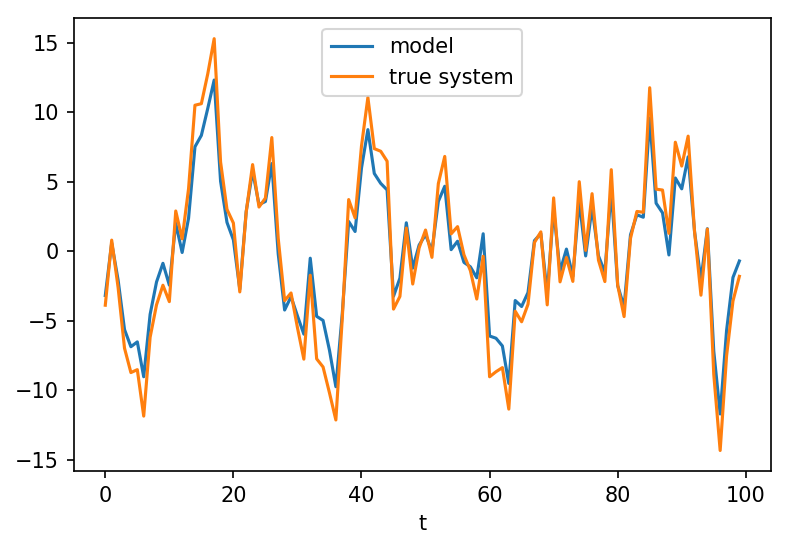

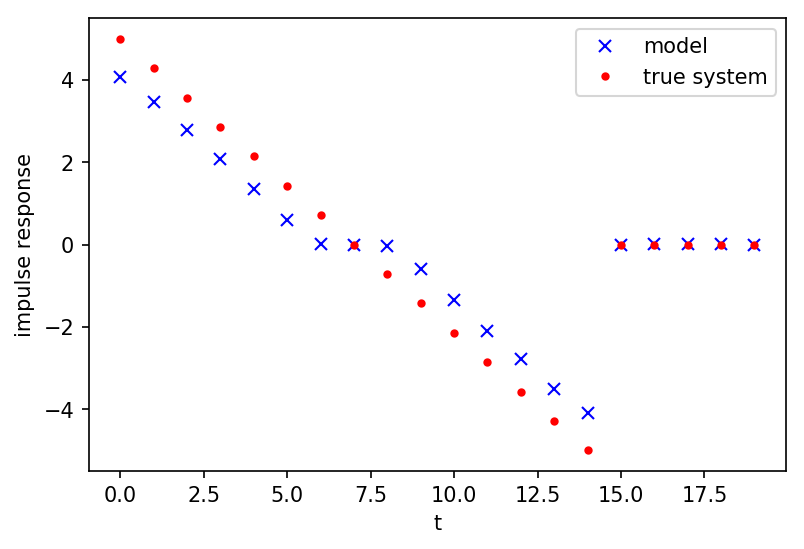

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
import matplotlib.pyplot as plt

m = VolterraModel(model_order, model_memory_len, include_constant_function=include_constant_function, dict_type=dict_type)

#scaling_parameter = 1
#stepsize_eq = scaling_parameter * np.sqrt(2 * np.log(2 * D) / (G_sq_eq * (real_est_batch_size + 1)))
#stepsize_mc = scaling_parameter * np.sqrt(2 * np.log(2 * D) / (G_sq_mc * (real_est_batch_size + 1)))

#print("DUAL AVERAGING")
#print("   Equation stepsize: {0}".format(stepsize_eq))
#print("Monte Carlo stepsize: {0}".format(stepsize_mc))

#alg = LazyEntropicDescentAlgorithm(m.dictionary, R=R, constraint='ball')
alg = AdaptiveLazyEntropicDescentAlgorithm(m.dictionary, R=R, constraint='ball')
model_parameters = alg.run(x_est, y_est, G_sq_eq)

m.set_parameters(model_parameters)
                   
y_ed = m.evaluate_output(x_val)

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_ed[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()


x = [1] + [0] * (sys_imp_resp_length + 4)
plt.rcParams['figure.dpi'] = 150
plt.plot(m.evaluate_output(x), 'bx')
plt.plot(true_sys.evaluate_output(x), 'r.')
plt.xlabel('t')
plt.ylabel('impulse response')
plt.legend(['model', 'true system'])
plt.show()

print(x)

## Aggregation algorithm

The algorithm aims to estimate Volterra model's parameters on an $\ell_1$-ball of radius $R$. 
Since, we know the $\ell_1$-norm of the true system's parameters we can choose optimal $R$.  

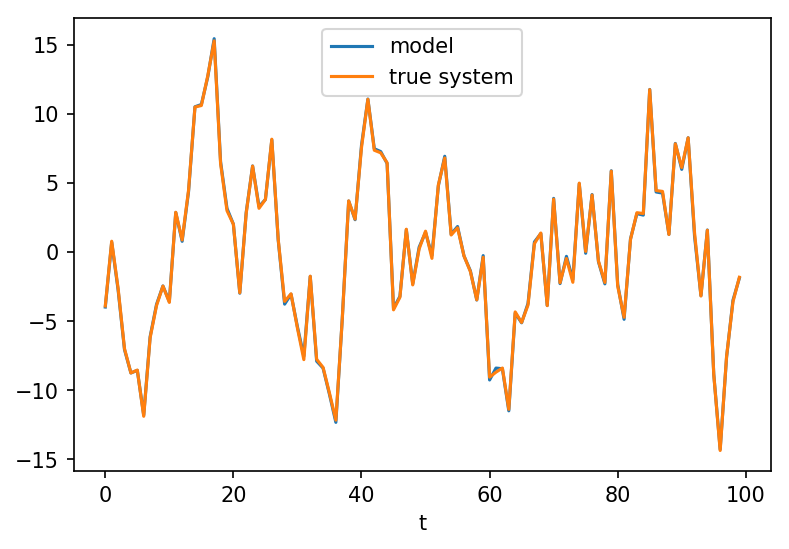

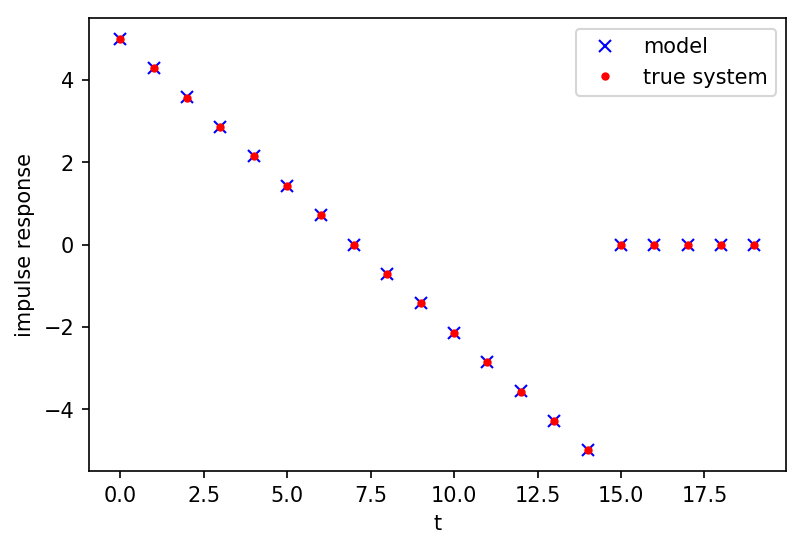

In [6]:
from aggregation import *
import matplotlib.pyplot as plt

# model parameters
model_order = 1
model_memory_len = sys_imp_resp_length
m = VolterraModel(model_order, model_memory_len)

params = aggregation_for_volterra(m.dictionary, x_est, y_est, R=np.linalg.norm(sys_impulse_response, 1))
m.set_parameters(params)

y_aggr = m.evaluate_output(x_val)

# plot data
plt.rcParams['figure.dpi'] = 150
plt.plot(y_aggr[:100])
plt.plot(y_val[:100])
plt.xlabel('t')
plt.legend(['model', 'true system'])
plt.show()

x = [1] + [0] * (sys_imp_resp_length + 4)
plt.rcParams['figure.dpi'] = 150
plt.plot(m.evaluate_output(x), 'bx')
plt.plot(true_sys.evaluate_output(x), 'r.')
plt.xlabel('t')
plt.ylabel('impulse response')
plt.legend(['model', 'true system'])
plt.show()
